# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Reacher.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    

class Agent(nn.Module):
    def __init__(self, h1_size=64, h2_size=32):
        super(Agent, self).__init__()
        #self.env = env
        # state, hidden layer, action sizes
        self.s_size = 33 #env_info.vector_observations.shape[1]
        self.h1_size = h1_size
        self.h2_size = h2_size
        self.a_size = 4 #env.action_space.n-1
        print("Neural Network - Input: {}, Hidden Layer 1 {}, Hidden Layer 1 {}, Output {}".format(self.s_size, self.h1_size,self.h2_size, self.a_size))
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h1_size)
        self.fc2 = nn.Linear(self.h1_size, self.h2_size)
        self.fc3 = nn.Linear(self.h2_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h1_size = self.h1_size
        h2_size = self.h2_size
        a_size = self.a_size
        
        # separate the weights for each layer
        fc1_end = (s_size*h1_size)+h1_size
        fc1_W = torch.from_numpy(weights[:s_size*h1_size].reshape(s_size, h1_size))
        fc1_b = torch.from_numpy(weights[s_size*h1_size:fc1_end])
        
        fc2_end = fc1_end + (h1_size*h2_size)+h2_size
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end + h1_size*h2_size].reshape(h1_size, h2_size)) #h1-size * h2-size Ws
        fc2_b = torch.from_numpy(weights[fc1_end + h1_size*h2_size:fc2_end]) #h2-size bias
        
        fc3_W = torch.from_numpy(weights[fc2_end:fc2_end+(h2_size*a_size)].reshape(h2_size, a_size))
        fc3_b = torch.from_numpy(weights[fc2_end+(h2_size*a_size):])
                
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        
        self.fc3.weight.data.copy_(fc3_W.view_as(self.fc3.weight.data))
        self.fc3.bias.data.copy_(fc3_b.view_as(self.fc3.bias.data))
        
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h1_size +(self.h1_size + 1)*self.h2_size +(self.h2_size+1)*self.a_size
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x)) #values between -1 and 1
        return x.cpu().data.numpy().reshape(1,4)

        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        
        #state = self.env.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            actions = self.forward(state)
            env_info = env.step(actions)[brain_name]           # send action to the environment
            
            next_state = env_info.vector_observations[0]         # get next state (for each agent)
            reward = env_info.rewards[0]                         # get reward (for each agent)
            done = env_info.local_done[0]                        # see if episode finished 
            #state, reward, done, _ = self.env.step(action)
            
            episode_return += reward * math.pow(gamma, t)
            state = next_state
            if done:
                break
        return episode_return
    
agent = Agent().to(device)

Neural Network - Input: 33, Hidden Layer 1 64, Hidden Layer 1 32, Output 4


In [6]:
agent.get_weights_dim()

4388

Episode 1	 Real Score: 0.55
Episode 2	 Real Score: 1.35
Episode 3	 Real Score: 1.09
Episode 4	 Real Score: 2.36
Episode 5	 Real Score: 1.55
Episode 6	 Real Score: 0.70
Episode 7	 Real Score: 0.98
Episode 8	 Real Score: 1.19
Episode 9	 Real Score: 0.07
Episode 10	 Real Score: 0.80
Episode 10	Average Score: 1.06
Episode 11	 Real Score: 0.40
Episode 12	 Real Score: 1.25
Episode 13	 Real Score: 0.11
Episode 14	 Real Score: 1.86
Episode 15	 Real Score: 2.38
Episode 16	 Real Score: 0.40
Episode 17	 Real Score: 1.26
Episode 18	 Real Score: 1.26
Episode 19	 Real Score: 0.00
Episode 20	 Real Score: 1.57
Episode 20	Average Score: 1.06
Episode 21	 Real Score: 0.85
Episode 22	 Real Score: 0.99
Episode 23	 Real Score: 0.66
Episode 24	 Real Score: 2.11
Episode 25	 Real Score: 3.79
Episode 26	 Real Score: 2.35
Episode 27	 Real Score: 1.86
Episode 28	 Real Score: 2.40
Episode 29	 Real Score: 1.55
Episode 30	 Real Score: 0.65
Episode 30	Average Score: 1.38
Episode 31	 Real Score: 1.17
Episode 32	 Real 

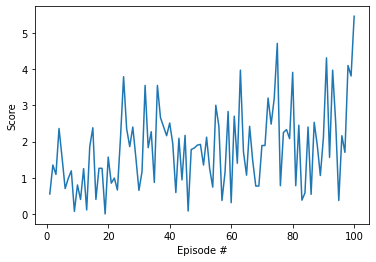

In [7]:
def evolutive (n_iterations=100, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=20)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        sigma*=.99
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_rewards=[rewards[i] for i in elite_idxs]
        elite_rewards +=- min(elite_rewards)+1 # no negative numbers
        elite_weights = [weights_pop[i] for i in elite_idxs]    
        
        best_weight = np.average(np.array(elite_weights),axis = 0, weights=elite_rewards)
        
        reward = agent.evaluate(best_weight, gamma=1.0)
        
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        print('Episode {}\t Real Score: {:.2f}'.format(i_iteration, reward))
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-20, np.mean(scores_deque)))
            break
    return scores

scores = evolutive()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```